# Train and test **U-Net** model

### _Step 1: Initialization_

In [34]:
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import matplotlib.pyplot as plt

IMAGE_DIR = 'data'
MASK_DIR = 'segmentation_masks'
NUM_CLASSES = 3

### _Step 2: Custom Dataset_

In [35]:
# Transforms
image_transform = T.Compose([
    T.Resize((240, 180)),
    T.ToTensor()
])

mask_transform = T.Compose([
    T.Resize((240, 180), interpolation=Image.NEAREST),
])

class UNetSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
        self.mask_filenames = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.image_dir, self.image_filenames[idx])).convert('RGB')
        mask = Image.open(os.path.join(self.mask_dir, self.mask_filenames[idx]))

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        mask = torch.from_numpy(np.array(mask)).long()
        return image, mask

# Prepare Dataset (train/test)
dataset = UNetSegmentationDataset(IMAGE_DIR, MASK_DIR, image_transform, mask_transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=8, num_workers=4, pin_memory=True)

### _Step 3: Define U-Net Model_

In [36]:
# Simple U-Net Model
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.middle = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # 60x45 → 120x90
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # 120x90 → 240x180
            nn.Conv2d(64, num_classes, 1)
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

### _Step 4: Training_

In [37]:
# Auxiliary code for performance tracking
def compute_iou(pred, target, num_classes):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))  # avoid division by zero
        else:
            ious.append(intersection / union)
    return ious

def compute_dice(pred, target, num_classes):
    dices = []
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        dice = (2 * intersection) / (pred_inds.sum().item() + target_inds.sum().item() + 1e-8)
        dices.append(dice)
    return dices

In [38]:
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)
scaler = GradScaler()

NUM_EPOCHS = 50
iou_history = []
dice_history = []
loss_history = []


for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

    for imgs, masks in progress_bar:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    scheduler.step(avg_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Avg Loss: {avg_loss:.4f}\n")
    print(f"Current LR: {current_lr:.6f}\n")

    model.eval()
    iou_scores = []
    dice_scores = []

    with torch.no_grad():
        for imgs, masks in test_loader:  # or val_loader if you have it
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

            for i in range(len(imgs)):
                iou = compute_iou(preds[i], masks[i], NUM_CLASSES)
                dice = compute_dice(preds[i], masks[i], NUM_CLASSES)
                iou_scores.append([x for x in iou if not isinstance(x, float) or not x != x])
                dice_scores.append(dice)

    mean_iou = sum(map(sum, iou_scores)) / sum(map(len, iou_scores))
    mean_dice = sum(map(sum, dice_scores)) / sum(map(len, dice_scores))

    loss_history.append(avg_loss)
    iou_history.append(mean_iou)
    dice_history.append(mean_dice)



<ipython-input-38-25a4c30c86e4>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/50:   0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-38-25a4c30c86e4>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/50: 100%|██████████| 500/500 [00:38<00:00, 13.11it/s, loss=0.0402]


Epoch 1/50, Avg Loss: 0.1856
Current LR: 0.001000


Epoch 2/50: 100%|██████████| 500/500 [00:39<00:00, 12.72it/s, loss=0.0242]

Epoch 2/50, Avg Loss: 0.0464
Current LR: 0.001000



Epoch 3/50: 100%|██████████| 500/500 [00:37<00:00, 13.29it/s, loss=0.161]

Epoch 3/50, Avg Loss: 0.0409
Current LR: 0.001000



Epoch 4/50: 100%|██████████| 500/500 [00:38<00:00, 12.98it/s, loss=0.0112]

Epoch 4/50, Avg Loss: 0.0379
Current LR: 0.001000



Epoch 5/50: 100%|██████████| 500/500 [00:38<00:00, 13.02it/s, loss=0.0121]

Epoch 5/50, Avg Loss: 0.0319
Current LR: 0.001000



Epoch 6/50: 100%|██████████| 500/500 [00:38<00:00, 12.99it/s, loss=0.00987]

Epoch 6/50, Avg Loss: 0.0303
Current LR: 0.001000



Epoch 7/50: 100%|██████████| 500/500 [00:38<00:00, 12.96it/s, loss=0.0489]

Epoch 7/50, Avg Loss: 0.0296
Current LR: 0.001000



Epoch 8/50: 100%|██████████| 500/500 [00:37<00:00, 13.38it/s, loss=0.0425]

Epoch 8/50, Avg Loss: 0.0314
Current LR: 0.001000



Epoch 9/50: 100%|██████████| 500/500 [00:38<00:00, 12.98it/s, loss=0.0252]

Epoch 9/50, Avg Loss: 0.0299
Current LR: 0.001000



Epoch 10/50: 100%|██████████| 500/500 [00:38<00:00, 12.84it/s, loss=0.0163]

Epoch 10/50, Avg Loss: 0.0272
Current LR: 0.001000



Epoch 11/50: 100%|██████████| 500/500 [00:38<00:00, 13.01it/s, loss=0.0297]

Epoch 11/50, Avg Loss: 0.0253
Current LR: 0.001000



Epoch 12/50: 100%|██████████| 500/500 [00:38<00:00, 12.96it/s, loss=0.0284]

Epoch 12/50, Avg Loss: 0.0240
Current LR: 0.001000



Epoch 13/50: 100%|██████████| 500/500 [00:38<00:00, 13.08it/s, loss=0.0108]

Epoch 13/50, Avg Loss: 0.0674
Current LR: 0.001000



Epoch 14/50: 100%|██████████| 500/500 [00:38<00:00, 13.03it/s, loss=0.0109]

Epoch 14/50, Avg Loss: 0.0246
Current LR: 0.001000



Epoch 15/50: 100%|██████████| 500/500 [00:37<00:00, 13.34it/s, loss=0.0272]

Epoch 15/50, Avg Loss: 0.0228
Current LR: 0.001000



Epoch 16/50: 100%|██████████| 500/500 [00:38<00:00, 13.03it/s, loss=0.0157]

Epoch 16/50, Avg Loss: 0.0220
Current LR: 0.001000



Epoch 17/50: 100%|██████████| 500/500 [00:38<00:00, 13.01it/s, loss=0.00576]

Epoch 17/50, Avg Loss: 0.0208
Current LR: 0.001000



Epoch 18/50: 100%|██████████| 500/500 [00:38<00:00, 13.01it/s, loss=0.0457]

Epoch 18/50, Avg Loss: 0.0207
Current LR: 0.001000



Epoch 19/50: 100%|██████████| 500/500 [00:38<00:00, 13.04it/s, loss=0.00873]

Epoch 19/50, Avg Loss: 0.0196
Current LR: 0.001000



Epoch 20/50: 100%|██████████| 500/500 [00:38<00:00, 12.90it/s, loss=0.00949]

Epoch 20/50, Avg Loss: 0.0192
Current LR: 0.001000



Epoch 21/50: 100%|██████████| 500/500 [00:39<00:00, 12.80it/s, loss=0.00743]

Epoch 21/50, Avg Loss: 0.0189
Current LR: 0.001000



Epoch 22/50: 100%|██████████| 500/500 [00:38<00:00, 12.97it/s, loss=0.0377]

Epoch 22/50, Avg Loss: 0.1356
Current LR: 0.001000



Epoch 23/50: 100%|██████████| 500/500 [00:39<00:00, 12.63it/s, loss=0.0256]

Epoch 23/50, Avg Loss: 0.0315
Current LR: 0.001000



Epoch 24/50: 100%|██████████| 500/500 [00:39<00:00, 12.55it/s, loss=0.0192]

Epoch 24/50, Avg Loss: 0.0269
Current LR: 0.001000



Epoch 25/50: 100%|██████████| 500/500 [00:38<00:00, 13.01it/s, loss=0.0278]

Epoch 25/50, Avg Loss: 0.0245
Current LR: 0.000500



Epoch 26/50: 100%|██████████| 500/500 [00:39<00:00, 12.61it/s, loss=0.0252]

Epoch 26/50, Avg Loss: 0.0224
Current LR: 0.000500



Epoch 27/50: 100%|██████████| 500/500 [00:38<00:00, 12.83it/s, loss=0.0123]

Epoch 27/50, Avg Loss: 0.0215
Current LR: 0.000500



Epoch 28/50: 100%|██████████| 500/500 [00:38<00:00, 13.16it/s, loss=0.0378]

Epoch 28/50, Avg Loss: 0.0210
Current LR: 0.000500



Epoch 29/50: 100%|██████████| 500/500 [00:39<00:00, 12.81it/s, loss=0.00864]

Epoch 29/50, Avg Loss: 0.0203
Current LR: 0.000250



Epoch 30/50: 100%|██████████| 500/500 [00:39<00:00, 12.76it/s, loss=0.00797]

Epoch 30/50, Avg Loss: 0.0194
Current LR: 0.000250



Epoch 31/50: 100%|██████████| 500/500 [00:38<00:00, 12.97it/s, loss=0.00928]

Epoch 31/50, Avg Loss: 0.0192
Current LR: 0.000250



Epoch 32/50: 100%|██████████| 500/500 [00:39<00:00, 12.77it/s, loss=0.00793]

Epoch 32/50, Avg Loss: 0.0190
Current LR: 0.000250



Epoch 33/50: 100%|██████████| 500/500 [00:38<00:00, 12.90it/s, loss=0.00848]

Epoch 33/50, Avg Loss: 0.0188
Current LR: 0.000250



Epoch 34/50: 100%|██████████| 500/500 [00:38<00:00, 12.95it/s, loss=0.00714]

Epoch 34/50, Avg Loss: 0.0186
Current LR: 0.000250



Epoch 35/50: 100%|██████████| 500/500 [00:38<00:00, 13.00it/s, loss=0.0359]

Epoch 35/50, Avg Loss: 0.0184
Current LR: 0.000250



Epoch 36/50: 100%|██████████| 500/500 [00:37<00:00, 13.30it/s, loss=0.00438]

Epoch 36/50, Avg Loss: 0.0183
Current LR: 0.000250



Epoch 37/50: 100%|██████████| 500/500 [00:38<00:00, 12.99it/s, loss=0.0288]

Epoch 37/50, Avg Loss: 0.0181
Current LR: 0.000250



Epoch 38/50: 100%|██████████| 500/500 [00:38<00:00, 13.04it/s, loss=0.00592]

Epoch 38/50, Avg Loss: 0.0179
Current LR: 0.000250



Epoch 39/50: 100%|██████████| 500/500 [00:38<00:00, 12.96it/s, loss=0.0237]

Epoch 39/50, Avg Loss: 0.0179
Current LR: 0.000250



Epoch 40/50: 100%|██████████| 500/500 [00:38<00:00, 12.99it/s, loss=0.00622]

Epoch 40/50, Avg Loss: 0.0176
Current LR: 0.000250



Epoch 41/50: 100%|██████████| 500/500 [00:38<00:00, 13.08it/s, loss=0.0269]

Epoch 41/50, Avg Loss: 0.0177
Current LR: 0.000250



Epoch 42/50: 100%|██████████| 500/500 [00:38<00:00, 12.98it/s, loss=0.0218]

Epoch 42/50, Avg Loss: 0.0180
Current LR: 0.000250



Epoch 43/50: 100%|██████████| 500/500 [00:37<00:00, 13.36it/s, loss=0.00829]

Epoch 43/50, Avg Loss: 0.0173
Current LR: 0.000250



Epoch 44/50: 100%|██████████| 500/500 [00:38<00:00, 12.94it/s, loss=0.00844]

Epoch 44/50, Avg Loss: 0.0172
Current LR: 0.000250



Epoch 45/50: 100%|██████████| 500/500 [00:38<00:00, 13.04it/s, loss=0.0068]

Epoch 45/50, Avg Loss: 0.0172
Current LR: 0.000250



Epoch 46/50: 100%|██████████| 500/500 [00:38<00:00, 12.98it/s, loss=0.00792]

Epoch 46/50, Avg Loss: 0.0170
Current LR: 0.000250



Epoch 47/50: 100%|██████████| 500/500 [00:39<00:00, 12.78it/s, loss=0.00758]

Epoch 47/50, Avg Loss: 0.0172
Current LR: 0.000250



Epoch 48/50: 100%|██████████| 500/500 [00:37<00:00, 13.30it/s, loss=0.0217]

Epoch 48/50, Avg Loss: 0.0169
Current LR: 0.000250



Epoch 49/50: 100%|██████████| 500/500 [00:38<00:00, 12.96it/s, loss=0.0272]

Epoch 49/50, Avg Loss: 0.0169
Current LR: 0.000250



Epoch 50/50: 100%|██████████| 500/500 [00:38<00:00, 13.10it/s, loss=0.00743]

Epoch 50/50, Avg Loss: 0.0168
Current LR: 0.000250


### _Step 5: Testing_

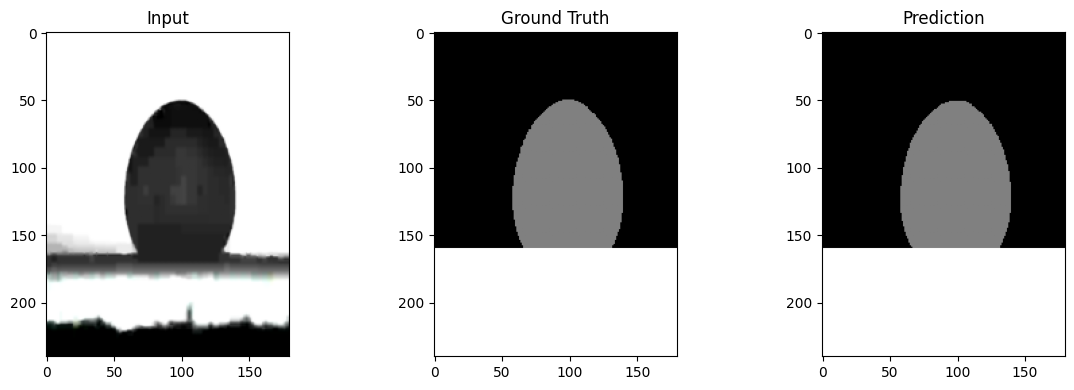

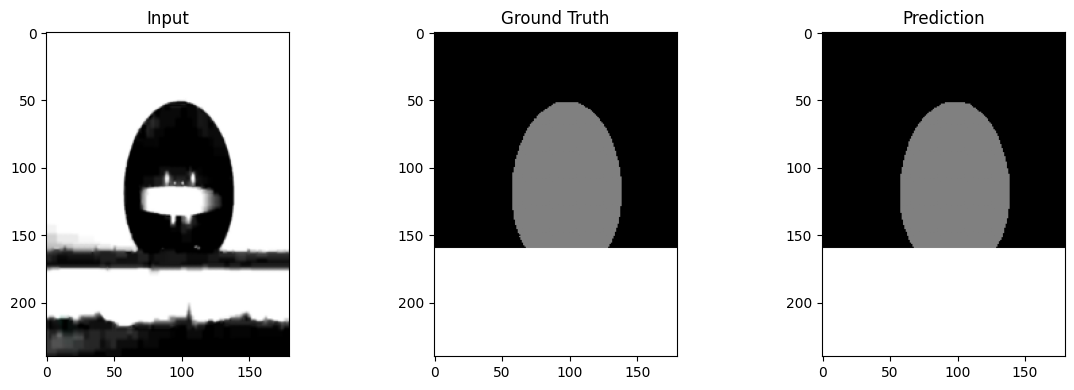

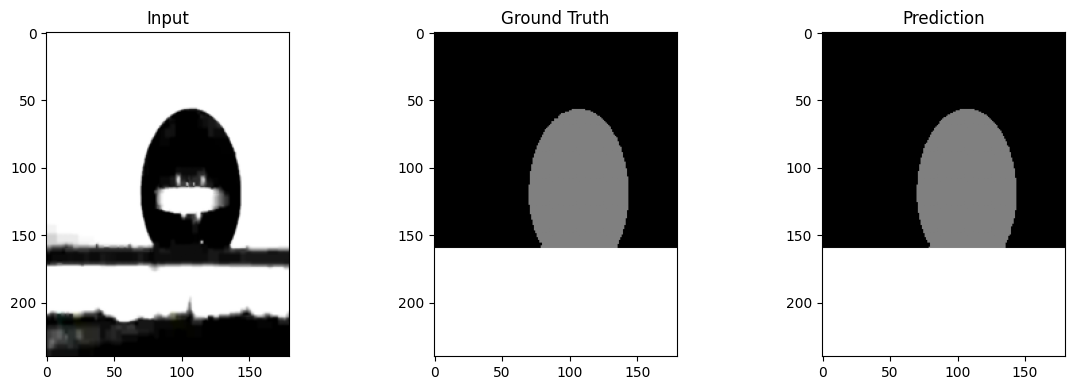

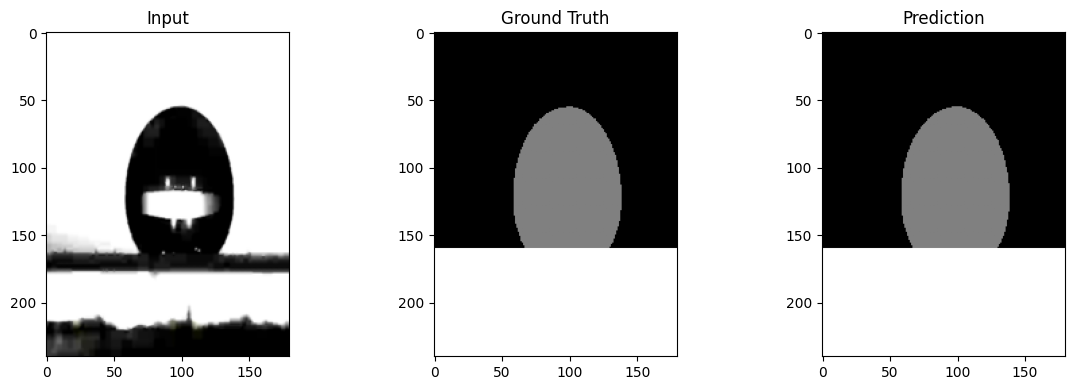

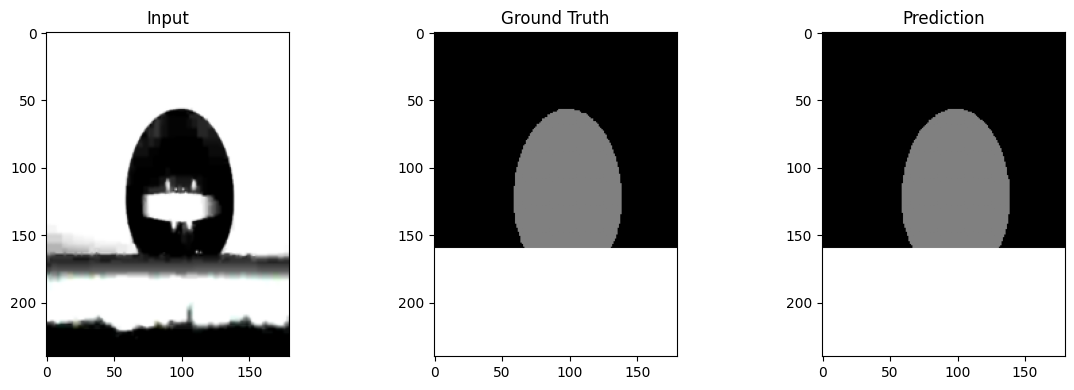

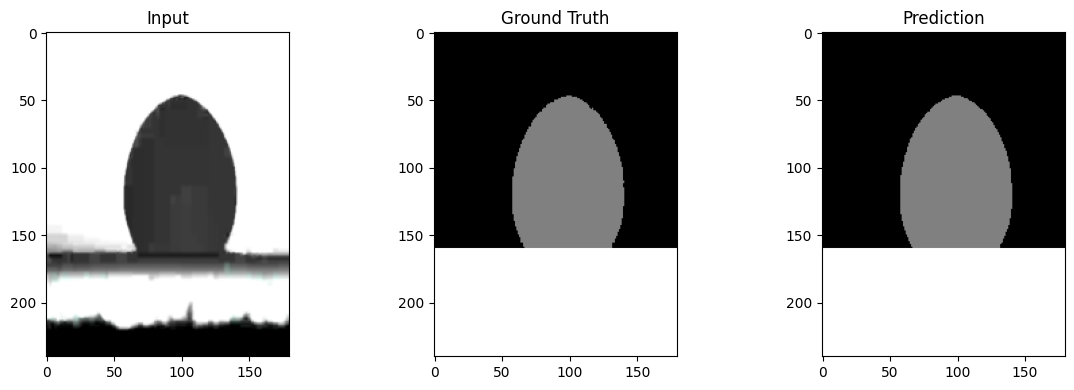

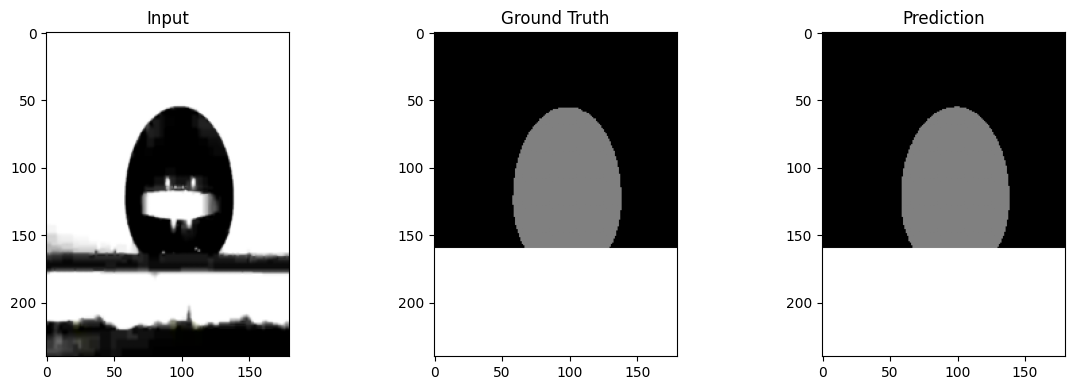

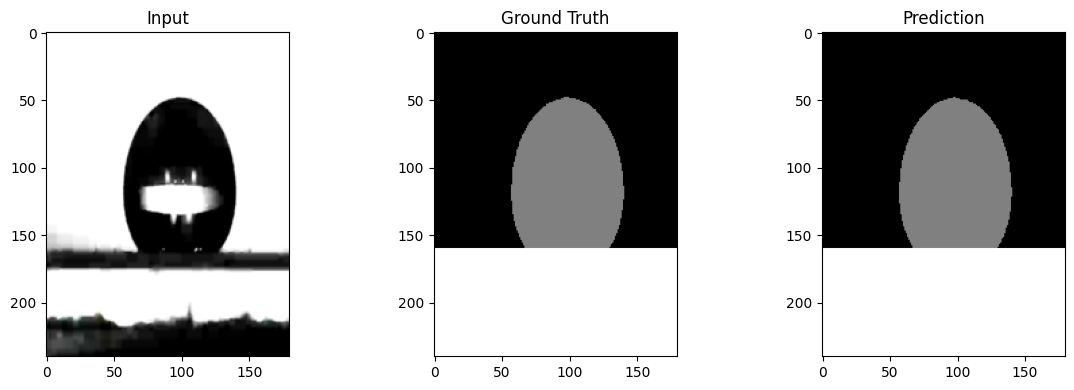

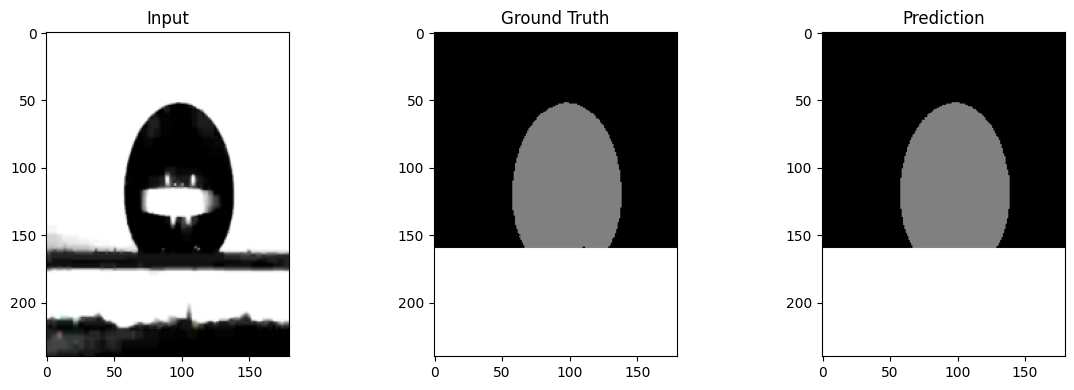

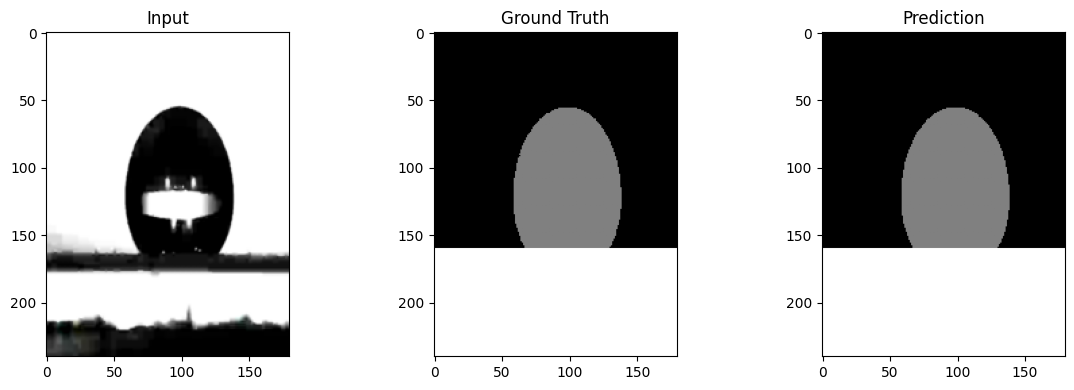

In [39]:
model.eval()
shown = 0
MAX_SAMPLES = 10

with torch.no_grad():
    for imgs, masks in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        imgs = imgs.cpu()
        masks = masks.cpu()

        for i in range(len(imgs)):
            if shown >= MAX_SAMPLES:
                break

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(imgs[i].permute(1, 2, 0))
            axs[0].set_title("Input")

            axs[1].imshow(masks[i], cmap='gray')
            axs[1].set_title("Ground Truth")

            axs[2].imshow(preds[i], cmap='gray')
            axs[2].set_title("Prediction")

            plt.tight_layout()
            plt.show()

            shown += 1

        if shown >= MAX_SAMPLES:
            break

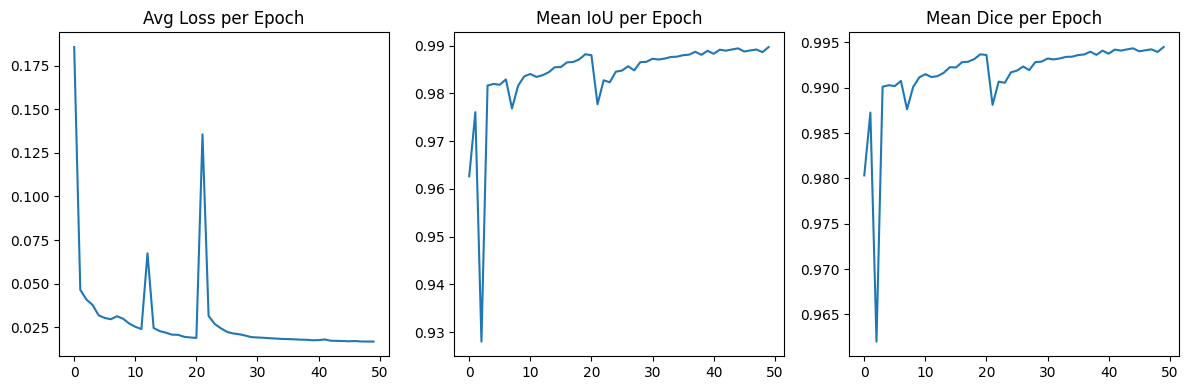

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(loss_history)
plt.title("Avg Loss per Epoch")

plt.subplot(1, 3, 2)
plt.plot(iou_history)
plt.title("Mean IoU per Epoch")

plt.subplot(1, 3, 3)
plt.plot(dice_history)
plt.title("Mean Dice per Epoch")

plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), "unet_model.pth")